In [1]:
%matplotlib inline


# PyBer_Challenge

There are two parts of this new challenge:
- create a Summary table
- visualize total fares by city type.

## Part 1, Create PyBer Summary

- Read city, ride data files and store in panda DataFrames.
- combine DataFrames to a new DataFrame pyber_data_df.
- get total_rides, total_drivers, total_fares for each city type.
- calculate average fare per ride, average fare per driver for city type.
- create a summary DataFrames, formatted and display it.

In [2]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd

# Read the city data file and store it in a pandas DataFrame.
city_data_to_load = "Resources/city_data.csv"
city_data_df = pd.read_csv(city_data_to_load)

# Read the ride data file and store it in a pandas DataFrame.
ride_data_to_load = "Resources/ride_data.csv"
ride_data_df = pd.read_csv(ride_data_to_load)

# Combine the data into a single dataframe: pyber_data_df
pyber_data_df = pd.merge(ride_data_df, city_data_df, how="left", on=["city", "city"])

# get total_rides, total_drivers, total_fares for each city type.
total_rides = pyber_data_df.groupby(["type"]).count()["ride_id"].rename("total_rides")
total_drivers = city_data_df.groupby(["type"]).sum()["driver_count"].rename("total_drivers")
total_fares = pyber_data_df.groupby(["type"]).sum()["fare"].rename("total_fares")

# calculate average fare per ride for city type.
fares_per_ride = total_fares / total_rides
fares_per_ride = fares_per_ride.rename("fare_per_ride")
# calculate average fare per driver for city type.
fares_per_driver = total_fares / total_drivers
fares_per_driver = fares_per_driver.rename("fare_per_driver")

# create a summary DataFrames
pyber_rides_summary_df = pd.concat([
        total_rides,
        total_drivers,
        total_fares,
        fares_per_ride,
        fares_per_driver],
        axis=1)

# format summary DataFrame and display it.
## create pretty_pyber_rides_summary_df for display.
pretty_pyber_rides_summary_df = pd.DataFrame({
    # number : add comma
    "Total Rides"   : pyber_rides_summary_df["total_rides"].map("{:,}".format),
    "Total Drivers" : pyber_rides_summary_df["total_drivers"].map("{:,}".format),
    # money : add $, comma, and keep two decimals 
    "Total Fares"   : pyber_rides_summary_df["total_fares"].map("${:,.2f}".format),
    "Average Fare per Ride"   : pyber_rides_summary_df["fare_per_ride"].map("${:,.2f}".format),
    "Average Fare per Driver" : pyber_rides_summary_df["fare_per_driver"].map("${:,.2f}".format)
    })

# no title
pretty_pyber_rides_summary_df.index.name = None

pretty_pyber_rides_summary_df

,Total Rides,Total Drivers,Total Fares,Average Fare per Ride,Average Fare per Driver
Rural,125,78,"$4,327.93",$34.62,$55.49
Suburban,625,490,"$19,356.33",$30.97,$39.50
Urban,"1,625","2,405","$39,854.38",$24.53,$16.57


## Part 2, Visualize Weekly Fares by City Type

Data processing and visualizing.

### data processing (and excises per instructions)
- per instructions, rename the DataFrame columns.
- per instructions, set the index to "Date" Column
- per instructions, create a new DataFrame with "Date", "City Type" and "Fare" columns.
    note: column "City" is included, just for column delete excise next.
- delete Column "City" in the new DataFrame.
- round the "Date" Column to day unit.
- create a DataFrame groupby "City Type" and "Date", sum up "Fare"
- create a pivot table with index being "Date"
- keep given date range, and resample to weekly.
    note: 1st week is adjusted to 7 days.

In [3]:
# rename columns (if no renamed yet)
if "city" in pyber_data_df.columns:
    pyber_data_df.rename(columns={
        "city" : "City",
        "date" : "Date",
        "fare" : "Fare",
        "type" : "City Type",    
        "ride_id"      : "Ride Id",
        "driver_count" : "No. Drivers"},
        inplace = True)
pyber_data_df.head(2)

,City,Date,Fare,Ride Id,No. Drivers,City Type
0,Lake Jonathanshire,2019-01-14 10:14:22,13.83,5739410935873,5,Urban
1,South Michelleport,2019-03-04 18:24:09,30.24,2343912425577,72,Urban


In [4]:
# set "Date" to be the index (if not changed yet)
if "Date" in pyber_data_df.columns:
    pyber_data_df.set_index("Date", inplace=True)
pyber_data_df.head(2)

,City,Fare,Ride Id,No. Drivers,City Type
Date,,,,,
2019-01-14 10:14:22,Lake Jonathanshire,13.83,5739410935873,5,Urban
2019-03-04 18:24:09,South Michelleport,30.24,2343912425577,72,Urban


In [5]:
# make a new df by copying selected columns. (Add "City" for column drop next)
pyber_fare_df = pyber_data_df[["City Type", "Fare", "City"]].copy()
pyber_fare_df.head(2)

,City Type,Fare,City
Date,,,
2019-01-14 10:14:22,Urban,13.83,Lake Jonathanshire
2019-03-04 18:24:09,Urban,30.24,South Michelleport


In [6]:
# drop "City" column
pyber_fare_df.drop("City", axis=1, inplace=True)
pyber_fare_df.head(2)

,City Type,Fare
Date,,
2019-01-14 10:14:22,Urban,13.83
2019-03-04 18:24:09,Urban,30.24


In [7]:
# convert index to DatetimeIndex, and round to day
pyber_fare_df.index = pd.to_datetime(pyber_fare_df.index)
pyber_fare_df.index = pyber_fare_df.index.round("D")
pyber_fare_df.head(2)

,City Type,Fare
Date,,
2019-01-14,Urban,13.83
2019-03-05,Urban,30.24


In [8]:
# groupby "City Type" and "Date", and get the "Fare" subtotal.
# this is a Series, so call it city_type_fare_series.
city_type_fare_series = pyber_fare_df.groupby(["City Type", "Date"]).sum()["Fare"]

# after reset_index(), becomes a DataFrame. name it city_type_fare_df.
city_type_fare_df = city_type_fare_series.reset_index()
city_type_fare_df.head(2)

,City Type,Date,Fare
0,Rural,2019-01-01,43.69
1,Rural,2019-01-02,52.12


In [9]:
# create a pivot table.
pivot_df = pd.pivot_table(city_type_fare_df, values="Fare", index="Date", columns="City Type")
pivot_df.head(2)

City Type,Rural,Suburban,Urban
Date,,,
2019-01-01,43.69,71.81,56.23
2019-01-02,52.12,184.94,264.68


In [10]:
# only keep data from the given dates
pivot_df = pivot_df.loc['2019-01-01':'2019-04-28']

# resmaple into weekly bins, call it pyber_pivot_df.
# Note: Nan is treated as 0; 1st week has 6 days; "Date" with the ending date. 
pyber_pivot_df = pivot_df.resample("W").sum()
pyber_pivot_df.head(2)

City Type,Rural,Suburban,Urban
Date,,,
2019-01-06,187.92,721.60,1529.53
2019-01-13,67.65,1012.53,2045.74


In [11]:
# normalize 1st week (01-01, ..., 01-06) to 7 days, scale up (7/6.0):
pyber_pivot_df.iloc[0] = pyber_pivot_df.iloc[0] * (7 / 6.0)
pyber_pivot_df.head(2)

City Type,Rural,Suburban,Urban
Date,,,
2019-01-06,219.24,841.866667,1784.451667
2019-01-13,67.65,1012.530000,2045.740000


### multi-line plot of weekly fares
- use specified style.
- use object-oriented interface.
- try to match existing color scheme.
- plot.
    Note: date is weekly ending date.

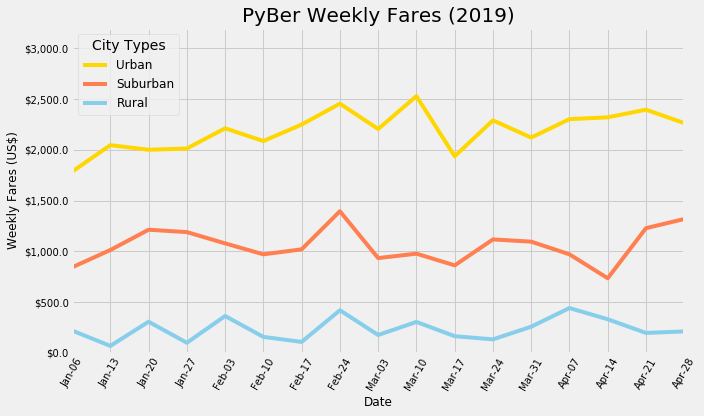

In [12]:
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

# use the specified style
plt.style.use('fivethirtyeight')

# create figure and subplot. enlarge the figure.
fig = plt.figure(1, figsize=(10, 6))
ax = fig.add_subplot()

# plot on the given ax, using same color scheme.
#colors = ["gold", "skyblue", "coral"]
colors = ["skyblue", "coral", "gold"]
pyber_pivot_df.plot(kind="line", ax=ax, color=colors)

# add title, xlable and ylabel.
ax.set_title("PyBer Weekly Fares (2019)", fontsize=20)
ax.set_xlabel("Date", fontsize=12)
ax.set_ylabel("Weekly Fares (US$)", fontsize=12)

# formating xaxis ticklabels.
ticklabels = [period.strftime('%b-%d') for period in pyber_pivot_df.index]
ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
# rotate a little
for tick_lbl in ax.get_xticklabels():
    tick_lbl.set_rotation(60)

# extra space for legend.    
ax.set_ylim([0, 3200])
# formating yaxis: add $ & comma sign.
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '${:,}'.format(x)))
ax.yaxis.set_visible(True)

ax.tick_params(which='major', labelsize=10)

# legend    
handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), loc="best", title="City Types", fontsize=12)

# Save the figure.
plt.savefig("analysis/Fig8.png", bbox_inches = 'tight')

plt.tight_layout()

# all done
plt.show()